# demonstrate Confidence Interval construction with Laplace mechanism

** Load data and some utility functions

In [1]:
rm(list=ls())		# Remove any objects in memory
par(mfrow=c(1,1))   # Rebuild fresh plot window, if previously divided

#### Parameters ####

# Random draw from Laplace distribution
#
# mu numeric, center of the distribution
# b numeric, spread
# size integer, number of draws
# 
# return Random draws from Laplace distribution
# example:
# 
# rlap(size=1000)

rlap = function(mu=0, b=1, size=1) {
    p <- runif(size) - 0.5
    draws <- mu - b * sgn(p) * log(1 - 2 * abs(p))
    return(draws)
}


# Probability density for Laplace distribution
#
# x numeric, value
# mu numeric, center of the distribution
# b numeric, spread
# 
# return Density for elements of x
# example:
# 
# x <- seq(-3, 3, length.out=61)
# dlap(x)

dlap <- function(x, mu=0, b=1) {
    dens <- 0.5 * b * exp(-1 * abs(x - mu) / b)
    return(dens)
}


# Laplace Cumulative Distribution Function
# 
# Determines the probability a draw from a LaPlace distribution is less than 
#    or equal to the specified value.
#
# x Numeric, the value(s) at which the user wants to know the CDF height.
# mu Numeric, the center of the LaPlace distribution, defaults to 0.
# b Numeric, the spread of the LaPlace distribution, defaults to 1.
# 
# return Probability the LaPlace draw is less than or equal to \code{x}.
# example:
# 
# x <- 0
# plap(x)

plap <- function(x, mu=0, b=1) {
    cdf <- 0.5 + 0.5 * sgn(x - mu) * (1 - exp(-1 * (abs(x - mu) / b)))
    return(cdf)
}


# Quantile function for Laplace distribution
#
# p Numeric, vector of probabilities
# mu numeric, center of the distribution
# b numeric, spread
# return Quantile function
# example:
#
# probs <- c(0.05, 0.50, 0.95)
# qlap(probs)

qlap <- function(p, mu=0, b=1) {
    q <- ifelse(p < 0.5, mu + b * log(2 * p), mu - b * log(2 - 2 * p))
    return(q)
}

# Sign function
# 
# Function to determine what the sign of the passed values should be.
#
# x numeric, value or vector or values
# return The sign of passed values
# example:
#
# sgn(rnorm(10))


sgn <- function(x) {
    return(ifelse(x < 0, -1, 1))
}


library("foreign")
PUMSdata <- read.csv(file="https://raw.githubusercontent.com/privacytoolsproject/cs208/master/data/FultonPUMS5full.csv")   

 
data <- PUMSdata$educ    		# variable for means
populationTrue <- mean(data)


## Bound/Censor/Clip a variable to a range
clip <- function(x, lower, upper){
	x.clipped <- x
	x.clipped[x.clipped<lower] <- lower
	x.clipped[x.clipped>upper] <- upper
	return(x.clipped)	
}

## Sample with replacement from a vector
bootstrap <- function(x, y=NULL, n){
	index <- sample(x=1:length(x), size=n, replace=TRUE) 

	if(is.null(y)){
		return(x[index])
	}else{
		return(list(x=x[index], y=y[index]))
	}
}



**Show Laplace Distributions

pdf 
  2

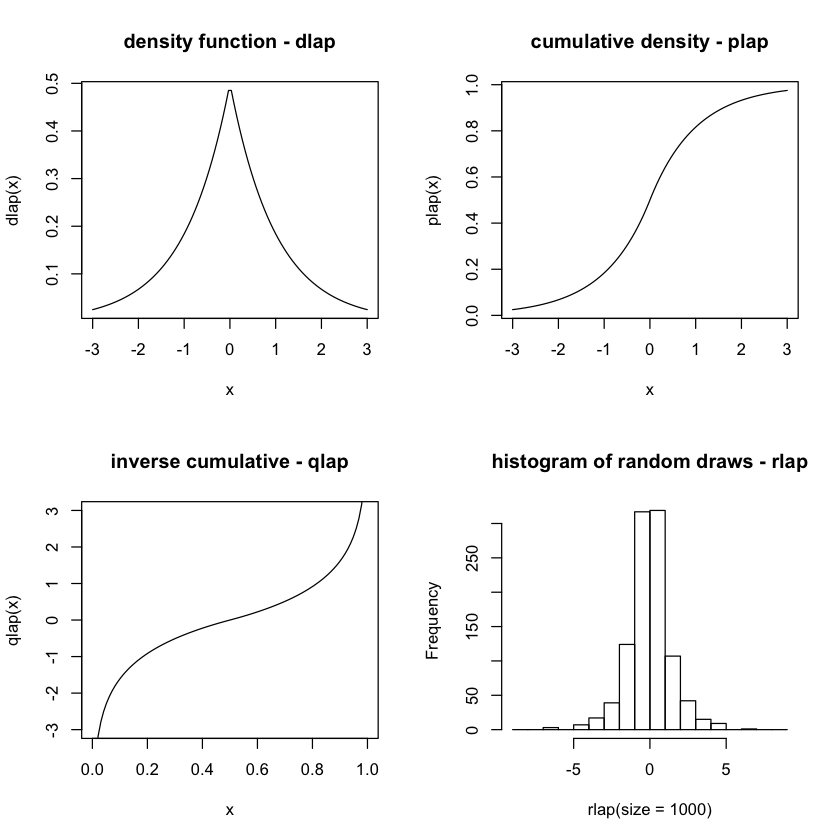

In [2]:
par(mfrow=c(2,2))
set.seed(123)

x<-seq(from=-3,to=3,length=100)

plot(x,dlap(x),type="l",main="density function - dlap")
plot(x,plap(x),type="l",main="cumulative density - plap")

x<-seq(from=.001,to=.999,length=100)
plot(x,qlap(x),type="l",ylim=c(-3,3),main="inverse cumulative - qlap")

hist(rlap(size=1000),main="histogram of random draws - rlap", breaks=-9:9)

dev.copy2pdf(file="./figs/laplaceDistributions.pdf")

**Construct a Confidence Interval as a Post-process release

In [3]:
## Confidence interval for mean release
ciPostProcess <- function(release, n, lower, upper, epsilon, alpha=0.05){
	sensitivity <- (upper - lower)/n
	scale <- sensitivity / epsilon

	ci.radius <- qlap(p=1 - (alpha/2), b=scale) # Completed from class example
	ci.lower.bound <- release - ci.radius       # Completed from class example
	ci.upper.bound <- release + ci.radius       # Completed from class example
    
	return(list(ciLower=ci.lower.bound, ciUpper=ci.upper.bound))
}

## Differentially private mean release
meanRelease <- function(x, lower, upper, epsilon){
	n <- length(x)
	sensitivity <- (upper - lower)/n
	scale <- sensitivity / epsilon

	x.clipped <- clip(x, lower, upper)
	sensitiveValue <- mean(x.clipped)
	DPrelease <- sensitiveValue + rlap(mu=0, b=scale, size=1)
	ci <- ciPostProcess(release=DPrelease, n=n, lower=lower, upper=upper, epsilon=epsilon)

	return(list(release=DPrelease, ci=ci, true=sensitiveValue))
}




** Show performance individually for a set of confidence intervals

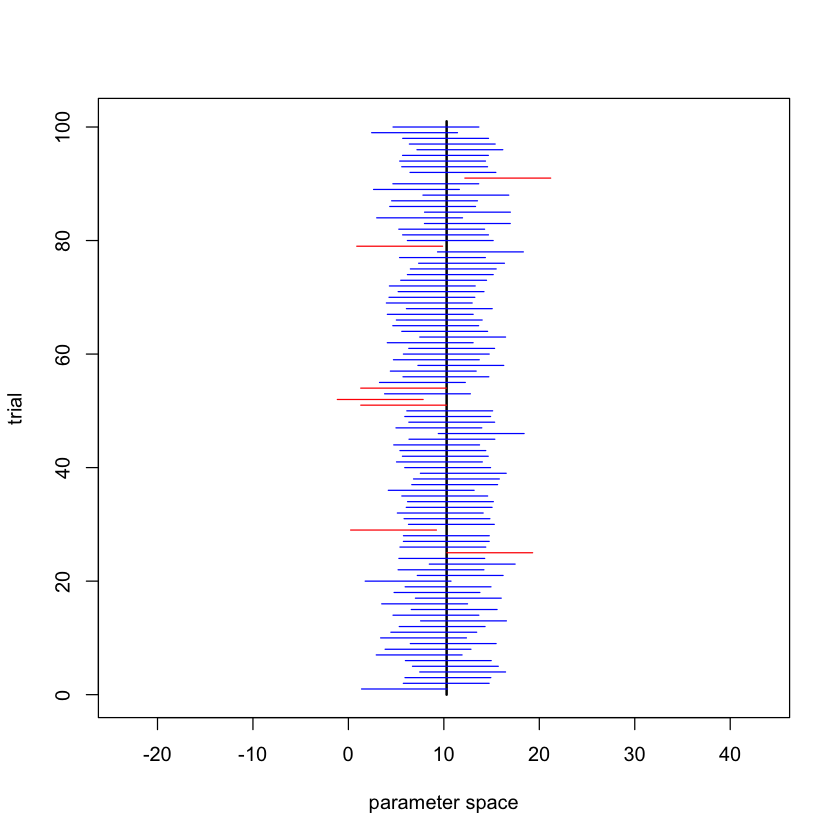

In [5]:
bootdata <- bootstrap(x=data, n=100)
true <- mean(bootdata)
n.sims <- 100
epsilon <- 0.1
history <- matrix(NA, nrow=n.sims, ncol=3)
for(i in 1:n.sims){
	DPmean <- meanRelease(x=bootdata, lower=1, upper=16, epsilon=epsilon)
	history[i,1] <- DPmean$ci$ciLower
	history[i,2] <- DPmean$ci$ciUpper
	history[i,3] <- as.numeric(DPmean$ci$ciLower < true) + as.numeric(DPmean$ci$ciUpper > true)  # what values can this take?
}

ci.min<- min(history[,1])
ci.max<- max(history[,2])

allxlim <- c(2*ci.min-ci.max, 2*ci.max-ci.min)
col.set <- c("red","blue")
plot(x=c(true,true), y=c(0,n.sims+1), xlim=allxlim, type="l", lwd=2, xlab="parameter space", ylab="trial")
for(i in 1:n.sims){
	lines(x=c(history[i,1],history[i,2]), y=c(i,i), col=col.set[history[i,3]])
}

** Simulate Coverage across n and epsilon

In [8]:
n.sims <-1000
my.seq <- seq(from=log10(1), to=log10(0.01), length=50)     	# make evenly spaced in logarithmic space
ep.seq <- 10^my.seq						
myn <- 500
populationTrue <- mean(data)

rawhistory <- matrix(NA, nrow=length(ep.seq)*n.sims, ncol=3)  # matrix to store results
agghistory <- matrix(NA, nrow=length(ep.seq), ncol=2)         # matrix to store results
rawcount <- aggcount <- 0													# initialize counter															

for(i in 1:length(ep.seq)){
	aggcount <- aggcount + 1
	coverage <- NULL
	for(j in 1:n.sims){
		rawcount <- rawcount + 1
		bootdata <- bootstrap(x=data, n=myn)
		DPmean <- meanRelease(x=bootdata, lower=1, upper=16, epsilon=ep.seq[i])
		#coversTrue <- (DPmean$ci$ciLower < populationTrue) & (DPmean$ci$ciUpper > populationTrue) # We are not covering population truth
        coversTrue <- (DPmean$ci$ciLower < DPmean$true) & (DPmean$ci$ciUpper > DPmean$true)        # We are covering sample result
		coverage <- c(coverage, coversTrue)

		rawhistory[rawcount,1] <- DPmean$ci$ciLower
		rawhistory[rawcount,2] <- DPmean$ci$ciUpper
		rawhistory[rawcount,3] <- 1 + as.numeric(coversTrue)
	}
	agghistory[aggcount,1] <- ep.seq[i] 
	agghistory[aggcount,2] <- mean(coverage)
}

my.seq <- seq(from=log10(200), to=log10(5000), length=20)  	# make evenly spaced in logarithmic space
n.seq  <- round(10^my.seq)                                 	# round to integers
myepsilon <- 0.1

rawhistory <- matrix(NA, nrow=length(n.seq)*n.sims, ncol=3)  # matrix to store results
agghistory2 <- matrix(NA, nrow=length(n.seq), ncol=2)         # matrix to store results
rawcount <- aggcount <- 0													# initialize counter															

for(i in 1:length(n.seq)){
	aggcount <- aggcount + 1
	coverage <- NULL
	for(j in 1:n.sims){
		rawcount <- rawcount + 1
		bootdata <- bootstrap(x=data, n=n.seq[i])
		DPmean <- meanRelease(x=bootdata, lower=1, upper=16, epsilon=myepsilon)
		#coversTrue <- (DPmean$ci$ciLower < populationTrue) & (DPmean$ci$ciUpper > populationTrue)  # We are not covering population truth
        coversTrue <- (DPmean$ci$ciLower < DPmean$true) & (DPmean$ci$ciUpper > DPmean$true)             # We are covering sample result
		coverage <- c(coverage, coversTrue)

		rawhistory[rawcount,1] <- DPmean$ci$ciLower
		rawhistory[rawcount,2] <- DPmean$ci$ciUpper
		rawhistory[rawcount,3] <- 1 + as.numeric(coversTrue)
	}
	agghistory2[aggcount,1] <- n.seq[i] 
	agghistory2[aggcount,2] <- mean(coverage)
}


**Graph results of coverage experiment

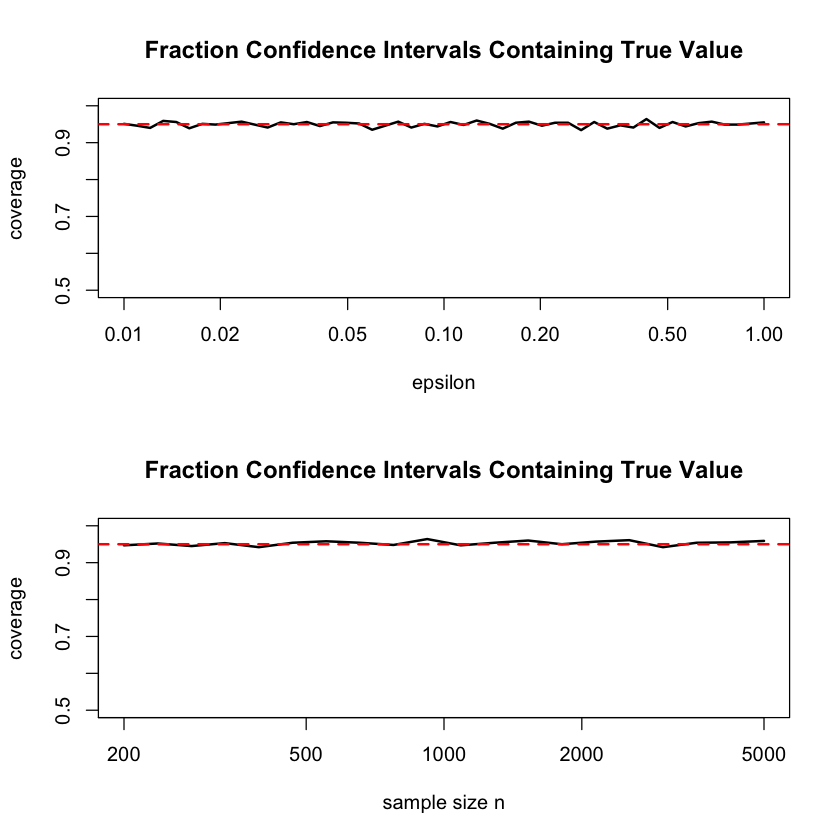

In [9]:
par(mfcol=c(2,1))

plot(x=agghistory[,1], y=agghistory[,2], log="x", type="l", ylim=c(0.5,1), lwd=2, col="black", xlab="epsilon", ylab="coverage", main="Fraction Confidence Intervals Containing True Value")
abline(h=0.95, lwd=2, lty=2, col="red")

plot(x=agghistory2[,1], y=agghistory2[,2], log="x", type="l", ylim=c(0.5,1), lwd=2, col="black", xlab="sample size n", ylab="coverage", main="Fraction Confidence Intervals Containing True Value")
abline(h=0.95, lwd=2, lty=2, col="red")
